# 0001_fastai_Is it a bird? Creating a model from your own data

In [ ]:
#| default_exp delete_bird

## Useful Course sites

**Official course site**:  for lesson [1](https://course.fast.ai/Lessons/lesson1.html)    

**Official notebooks** [repo](https://github.com/fastai/course22), on [nbviewer](https://nbviewer.org/github/fastai/course22/tree/master/)

Official **Is it a bird** [notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) on kaggle     


In [ ]:
from fastdebug.utils import *
from __future__ import annotations

## mamba update -q -y fastai; pip install -Uqq

In [ ]:
#| eval: false
# !mamba update -q -y fastai

In [ ]:
#| eval: false
# !pip install -Uqq duckduckgo_search

## fastai, duckduckgo_search

In [ ]:
from fastdebug.utils import *
from fastdebug.core import *

In [ ]:
import fastai

In [ ]:
whichversion("fastai")

fastai: 2.7.9 
fastai simplifies training fast and accurate neural nets using modern best practices    
Jeremy Howard, Sylvain Gugger, and contributors 
https://github.com/fastai/fastai/tree/master/     
python_version: >=3.7     
/Users/Natsume/mambaforge/lib/python3.9/site-packages/fastai


In [ ]:
whatinside(fastai, lib=True)

The library has 24 modules
['_modidx',
 '_nbdev',
 '_pytorch_doc',
 'basics',
 'callback',
 'collab',
 'data',
 'distributed',
 'fp16_utils',
 'imports',
 'interpret',
 'layers',
 'learner',
 'losses',
 'medical',
 'metrics',
 'optimizer',
 'tabular',
 'test_utils',
 'text',
 'torch_basics',
 'torch_core',
 'torch_imports',
 'vision']


In [ ]:
import duckduckgo_search

In [ ]:
whichversion("duckduckgo_search")

duckduckgo-search: 2.2.2 
Search for words, documents, images, news, maps and text translation using the DuckDuckGo.com search engine.    
deedy5 
https://github.com/deedy5/duckduckgo_search     
python_version: >=3.7     
/Users/Natsume/mambaforge/lib/python3.9/site-packages/duckduckgo_search


In [ ]:
whatinside(duckduckgo_search)

duckduckgo_search has: 
0 items in its __all__, and 
6 user defined functions, 
0 classes or class objects, 
0 builtin funcs and methods, and
6 callables.

Duckduckgo_search
~~~~~~~~~~~~~~
Search for words, documents, images, videos, news, maps and text translation
using the DuckDuckGo.com search engine.


In [ ]:
whatinside(duckduckgo_search, func=True)

duckduckgo_search has: 
0 items in its __all__, and 
6 user defined functions, 
0 classes or class objects, 
0 builtin funcs and methods, and
6 callables.

Duckduckgo_search
~~~~~~~~~~~~~~
Search for words, documents, images, videos, news, maps and text translation
using the DuckDuckGo.com search engine.
The user defined functions are:
ddg:               function    (keywords, region='wt-wt', safesearch='Moderate', time=None, max_results=25, output=None)
ddg_images:        function    (keywords, region='wt-wt', safesearch='Moderate', time=None, size=None, color=None, type_image=None, layout=None, license_image=None, max_results=100, output=None, download=False)
ddg_maps:          function    (keywords, place=None, street=None, city=None, county=None, state=None, country=None, postalcode=None, latitude=None, longitude=None, radius=0, max_results=None, output=None)
ddg_news:          function    (keywords, region='wt-wt', safesearch='Moderate', time=None, max_results=25, output=None)
ddg

## Experiment with images using duckduckgo_search library
Trying out duckduckgo_search lib to extract image urls and use fastdownload to download image files and display them.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

### src: itemgot(self:L, *idxs)
apply itemgetter(idx) to every item of self or L

In [ ]:
@patch
# @snoop
def itemgot(self:L, *idxs):
    "Create new `L` with item `idx` of all `items`"
        # itemgetter(idx) is a func, and is applied to every item of x, so I have itemgetter('image')(x)
        # but itemgetter('image')(x) is in fact x['image'], according to itemgetter.__init__ below    
### the offiical version: can take only one idx such as `image` or `url`
#     x = self
#     for idx in idxs: x = x.map(itemgetter(idx))  
#     return x

### my version can take on both or more than `image` and `url`
    res = []
    for idx in idxs: 
        res.append(self.map(itemgetter(idx)))
    res = res if len(res) > 1 else res[0] if len(res) == 1 else None
    return res


# ~/mambaforge/lib/python3.9/site-packages/fastcore/foundation.py

### src: itemgetter
After f = itemgetter(2), the call f(r) returns r[2].

After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])

In [ ]:
class itemgetter:
    """
    Return a callable object that fetches the given item(s) from its operand. The following examples are very illuminating.
    After f = itemgetter(2), the call f(r) returns r[2].
    After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
    """
    __slots__ = ('_items', '_call')
#     @snoop
    def __init__(self, item, *items):
        if not items:
            self._items = (item,)
#             @snoop            
            def func(obj):
                return obj[item]
            self._call = func
        else:
            self._items = items = (item,) + items
#             @snoop
            def func(obj):
                return tuple(obj[i] for i in items)
            self._call = func
#     @snoop
    def __call__(self, obj):
        return self._call(obj)

    def __repr__(self):
        return '%s.%s(%s)' % (self.__class__.__module__,
                              self.__class__.__name__,
                              ', '.join(map(repr, self._items)))

    def __reduce__(self):
        return self.__class__, self._items
# ~/mambaforge/lib/python3.9/operator.py    

### ```search_images(term, max_images=30)```
use `ddg_images` and `L.itemtogt` and `itemgetter` to extract image download urls into a list

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
#     return pp(L(ddg_images(term, max_results=max_images))).itemgot('image')

In [ ]:
# help(ddg_images)
# ddg_images??
# L.itemgot??
# itemgetter??

In [ ]:
#|eval: false
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).

urls = search_images('bird photos', max_images=3)
urls
urls[0]

Searching for 'bird photos'


(#3) ['https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg','https://www.wallpapergeeks.com/wp-content/uploads/2014/02/Colorful-Bird-Perched-Wallpaper.jpg','https://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG']

'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'

In [ ]:
# fastnbs("search_images")

### ```download_url(urls[0], dest, show_progress=False)```
download a single image from a single url using fastdownload lib

In [ ]:
#|eval: false
from fastdownload import download_url
dest = 'bird.jpg' # dest is a filename
download_url(urls[0], dest, show_progress=True)

Path('bird.jpg')

### ```Image.open(filename)```

In [ ]:
from fastai.vision.all import *

In [ ]:
im = Image.open(dest)
im.width
im.height

2593

2542

### ```Image.Image.to_thumb```
Same as `thumbnail` to display image in a square with specified h and w, but uses a copy

In [ ]:
@patch
@snoop
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: 
        w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/core.py
# Type:      method

08:37:26.08 >>> Call to to_thumb in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_95976/1866859134.py", line 3
08:37:26.08 ...... self = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2593x2542>
08:37:26.08 ...... h = 256
08:37:26.08 ...... w = 256
08:37:26.08    3 | def to_thumb(self:Image.Image, h, w=None):
08:37:26.08    5 |     if w is None: 
08:37:26.08    7 |     im = self.copy()
08:37:26.18 .......... im = <PIL.Image.Image image mode=RGB size=2593x2542>
08:37:26.18    8 |     im.thumbnail((w,h))
08:37:26.19 .......... im = <PIL.Image.Image image mode=RGB size=256x251>
08:37:26.19    9 |     return im
08:37:26.19 <<< Return value from to_thumb: <PIL.Image.Image image mode=RGB size=256x251>


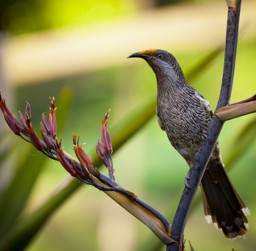

In [ ]:
im.to_thumb(256,256)

In [ ]:
@patch
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im

Searching for 'Spinosaurus aegyptiacus photos'


Path('forest.jpg')

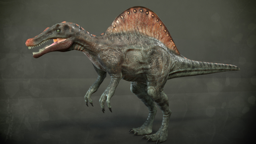

In [ ]:
#|eval: false
download_url(search_images('Spinosaurus aegyptiacus photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

### PILImage.create or PILBase.create(fn, **kwargs)
Open an `Image` from `fn`, which can be path or str, Tensor, numpy, ndarray, bytes

In [ ]:
doc(PILImage.create)

In [ ]:
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    @snoop
    def create(cls, fn:Path|str|Tensor|ndarray|bytes, **kwargs)->None:
        "Open an `Image` from path `fn`"
        if isinstance(fn,TensorImage): 
            fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn, TensorMask): 
            fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): 
            fn = fn.numpy()
        if isinstance(fn,ndarray): 
            return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): 
            fn = io.BytesIO(fn)
        pp(cls._open_args, kwargs, merge(cls._open_args, kwargs))
        res = cls(load_image(fn, **merge(cls._open_args, kwargs)))
        return res

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

    def __repr__(self): return f'{self.__class__.__name__} mode={self.mode} size={"x".join([str(d) for d in self.size])}'


08:37:29.76 >>> Call to PILBase.create in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_95976/1026981879.py", line 7
08:37:29.76 .......... cls = <class '__main__.PILBase'>
08:37:29.76 .......... fn = 'forest.jpg'
08:37:29.76 .......... kwargs = {}
08:37:29.76    7 |     def create(cls, fn:Path|str|Tensor|ndarray|bytes, **kwargs)->None:
08:37:29.76    9 |         if isinstance(fn,TensorImage): 
08:37:29.76   11 |         if isinstance(fn, TensorMask): 
08:37:29.76   13 |         if isinstance(fn,Tensor): 
08:37:29.76   15 |         if isinstance(fn,ndarray): 
08:37:29.76   17 |         if isinstance(fn,bytes): 
08:37:29.76   19 |         pp(cls._open_args, kwargs, merge(cls._open_args, kwargs))
08:37:29.76 LOG:
08:37:30.07 .... cls._open_args = {'mode': 'RGB'}
08:37:30.07 .... kwargs = {}
08:37:30.07 .... merge(cls._open_args, kwargs) = {'mode': 'RGB'}
08:37:30.07   20 |         res = cls(load_image(fn, **merge(cls._open_args, kwargs)))
08:37:30.09 .............. res

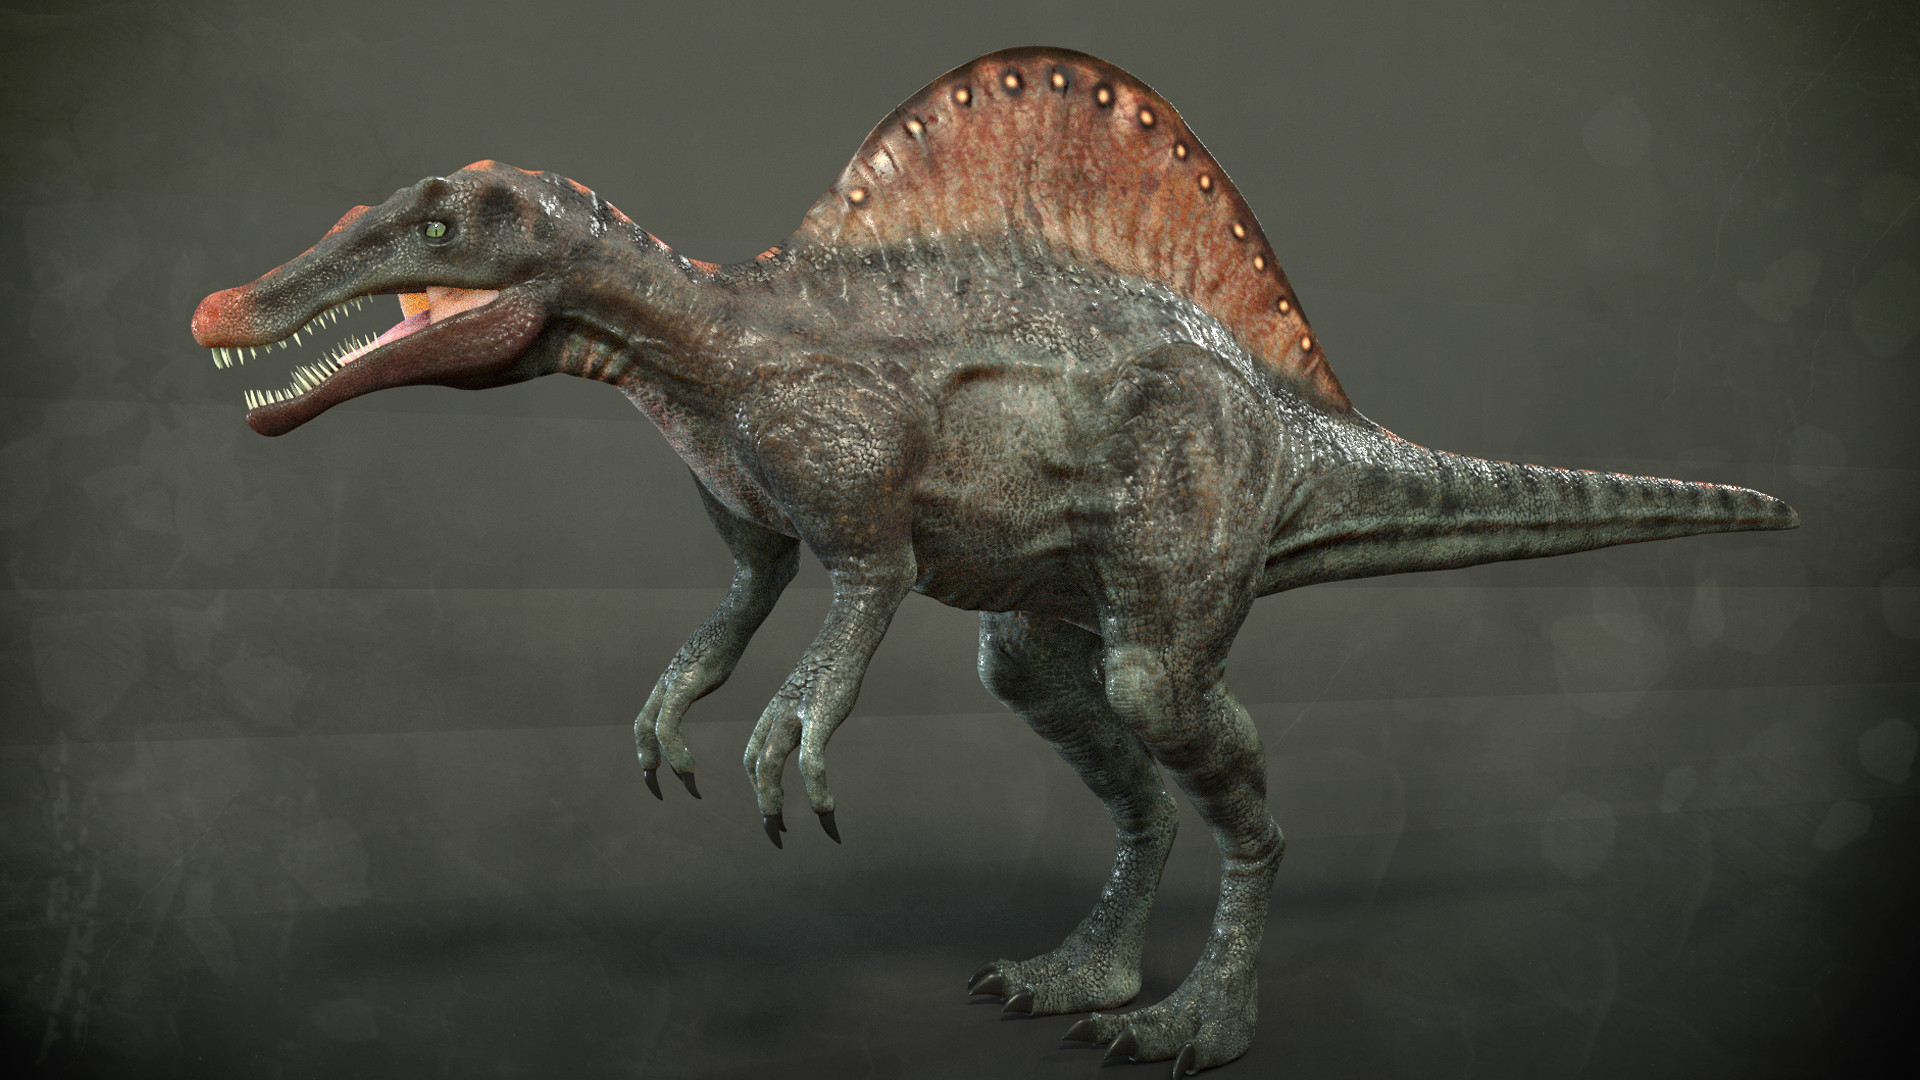

In [ ]:
# res = PILImage.create('forest.jpg')
res = PILBase.create('forest.jpg')
res

In [ ]:
@classmethod
@snoop
def create(cls:PILBase, fn:Path|str|Tensor|ndarray|bytes, **kwargs)->None:
    "Open an `Image` from path `fn`"
    if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
    if isinstance(fn, TensorMask): fn = fn.type(torch.uint8)
    if isinstance(fn,Tensor): fn = fn.numpy()
    if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
    if isinstance(fn,bytes): fn = io.BytesIO(fn)
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/core.py
# Type:      method

### ```Path.parent```

In [ ]:
#|eval: false
searches = 'forest','bird'
path = Path('bird_or_not')
(path/"forest").parent

Path('bird_or_not')

### ```mkdir(self:Path, mode=0o777, parents=False, exist_ok=False)```
Create path including parent path, if exist, don't create

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [ ]:
@patch
# @snoop
def mkdir(self:Path, mode=0o777, parents=False, exist_ok=False):
        """
        Create a new directory at this given path.
        """
        try:
            self._accessor.mkdir(self, mode)
        except FileNotFoundError:
            if not parents or self.parent == self:
                raise
            self.parent.mkdir(parents=True, exist_ok=True)
            self.mkdir(mode, parents=False, exist_ok=exist_ok)
        except OSError:
            # Cannot rely on checking for EEXIST, since the operating system
            # could give priority to other errors like EACCES or EROFS
            if not exist_ok or not self.is_dir():
                raise
# ~/mambaforge/lib/python3.9/pathlib.py                

In [ ]:
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)

### Path('bird_or_not')/'bird' and Path.ls()

In [ ]:
birds = (Path('bird_or_not')/'bird').ls()
forests = (Path('bird_or_not')/'forest').ls()

In [ ]:
len(birds)
len(forests)

1

1

In [ ]:
# fastnbs("path", "fastai", True)

## Search and Download images for your model

### resize_image(file, dest, src='.', max_size=None, n_channels=3, ext=None, ...)
Resize an image file to max_size, from src folder and saved a copy into dest folder

If the same filename is already inside dest folder, then do nothing

If the file to be resized is broken, then do nothing

If max_size is none, then make a copy and saved into dest/file

In [ ]:
@snoop
def resize_image(file, # str for image filename
                 dest, # str for image destination folder
                 src='.', # str for image source folder
                 max_size=None, # int for image maximum size to be changed
                 n_channels=3, ext=None,
                 img_format=None, resample=BILINEAR, resume=False, **kwargs ):
    "Resize file to dest to max_size"
    dest = Path(dest)
    
    dest_fname = dest/file
    dest_fname.parent.mkdir(exist_ok=True, parents=True)
    file = Path(src)/file
    if resume and dest_fname.exists(): return
    if not verify_image(file): return

    img = Image.open(file)
    imgarr = np.array(img)
    img_channels = 1 if len(imgarr.shape) == 2 else imgarr.shape[2]
    if ext is not None: dest_fname=dest_fname.with_suffix(ext) # specify file extensions
    if (max_size is not None and (img.height > max_size or img.width > max_size)) or img_channels != n_channels:
        if max_size is not None:
            pp(doc_sig(resize_to))
            pp(img.height, img.width)
            new_sz = resize_to(img, max_size) # keep the ratio
            pp(doc_sig(img.resize))
            img = img.resize(new_sz, resample=resample)
        if n_channels == 3: 
            img = img.convert("RGB")
        pp(doc_sig(img.save))
        img.save(dest_fname, img_format, **kwargs)
    elif file != dest_fname : 
        shutil.copy2(file, dest_fname)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
# doc(resize_image)

In [ ]:
file = 'bird.jpg'
src = Path('.')
dest = src/"resized"
resize_image(file, dest, src=src, max_size=400)
im = Image.open(dest/file)
test_eq(im.shape[1],400)
# (dest/file).unlink()

08:37:30.69 >>> Call to resize_image in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_95976/4048456158.py", line 2
08:37:30.69 ...... file = 'bird.jpg'
08:37:30.69 ...... dest = Path('resized')
08:37:30.69 ...... src = Path('.')
08:37:30.69 ...... max_size = 400
08:37:30.69 ...... n_channels = 3
08:37:30.69 ...... ext = None
08:37:30.69 ...... img_format = None
08:37:30.69 ...... resample = <Resampling.BILINEAR: 2>
08:37:30.69 ...... resume = False
08:37:30.69 ...... kwargs = {}
08:37:30.69    2 | def resize_image(file, # str for image filename
08:37:30.69    9 |     dest = Path(dest)
08:37:30.69   11 |     dest_fname = dest/file
08:37:30.69 .......... dest_fname = Path('resized/bird.jpg')
08:37:30.69   12 |     dest_fname.parent.mkdir(exist_ok=True, parents=True)
08:37:30.69   13 |     file = Path(src)/file
08:37:30.69 .......... file = Path('bird.jpg')
08:37:30.69   14 |     if resume and dest_fname.exists(): return
08:37:30.69   15 |     if not verify_image(file):

08:37:30.78   31 |         img.save(dest_fname, img_format, **kwargs)
08:37:30.78 <<< Return value from resize_image: None


In [ ]:
file = 'bird.jpg'
src = Path('.')
dest = src/"resized"
resize_image(file, dest, src=src, max_size=None) # just copy not size changed
im = Image.open(dest/file)
test_eq(im.shape[1],1920)

08:37:30.80 >>> Call to resize_image in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_95976/4048456158.py", line 2
08:37:30.80 ...... file = 'bird.jpg'
08:37:30.80 ...... dest = Path('resized')
08:37:30.80 ...... src = Path('.')
08:37:30.80 ...... max_size = None
08:37:30.80 ...... n_channels = 3
08:37:30.80 ...... ext = None
08:37:30.80 ...... img_format = None
08:37:30.80 ...... resample = <Resampling.BILINEAR: 2>
08:37:30.80 ...... resume = False
08:37:30.80 ...... kwargs = {}
08:37:30.80    2 | def resize_image(file, # str for image filename
08:37:30.81    9 |     dest = Path(dest)
08:37:30.81   11 |     dest_fname = dest/file
08:37:30.81 .......... dest_fname = Path('resized/bird.jpg')
08:37:30.81   12 |     dest_fname.parent.mkdir(exist_ok=True, parents=True)
08:37:30.81   13 |     file = Path(src)/file
08:37:30.81 .......... file = Path('bird.jpg')
08:37:30.81   14 |     if resume and dest_fname.exists(): return
08:37:30.81   15 |     if not verify_image(file)

In [ ]:
def resize_image(file, dest, src='.', max_size=None, n_channels=3, ext=None,
                 img_format=None, resample=BILINEAR, resume=False, **kwargs ):
    "Resize file to dest to max_size"
    dest = Path(dest)
    
    dest_fname = dest/file
    dest_fname.parent.mkdir(exist_ok=True, parents=True)
    file = Path(src)/file
    if resume and dest_fname.exists(): return
    if not verify_image(file): return

    img = Image.open(file)
    imgarr = np.array(img)
    img_channels = 1 if len(imgarr.shape) == 2 else imgarr.shape[2]
    if ext is not None: dest_fname=dest_fname.with_suffix(ext)
    if (max_size is not None and (img.height > max_size or img.width > max_size)) or img_channels != n_channels:
        if max_size is not None:
            new_sz = resize_to(img, max_size)
            img = img.resize(new_sz, resample=resample)
        if n_channels == 3: img = img.convert("RGB")
        img.save(dest_fname, img_format, **kwargs)
    elif file != dest_fname : shutil.copy2(file, dest_fname)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

### resize_images(path, max_workers=defaults.cpus, max_size=None, recurse=False,..)
Resize files on path recursively to dest to max_size

'recursively' means if images in subfolders will be resized too, and the subfolders will be created if dest and src are not the same folder

In [ ]:
@snoop
def resize_images(path, max_workers=defaults.cpus, max_size=None, recurse=False,
                  dest=Path('.'), n_channels=3, ext=None, img_format=None, resample=BILINEAR,
                  resume=None, **kwargs):
    "Resize files on path recursively to dest to max_size"
    path = Path(path)
    if resume is None and dest != Path('.'): 
        resume=False
    os.makedirs(dest, exist_ok=True)
    files = get_image_files(path, recurse=recurse)
    files = [o.relative_to(path) for o in files]
    parallel(resize_image, files, src=path, n_workers=max_workers, max_size=max_size, dest=dest, n_channels=n_channels, ext=ext,
                   img_format=img_format, resample=resample, resume=resume, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
dest = Path(".")/'try_resize_images'
resize_images('bird_or_not', max_size=100, dest=dest, max_workers=0, recurse=True) # try recurse=True to check the difference

08:37:30.91 >>> Call to resize_images in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_95976/1408674014.py", line 2
08:37:30.91 ...... path = 'bird_or_not'
08:37:30.91 ...... max_workers = 0
08:37:30.91 ...... max_size = 100
08:37:30.91 ...... recurse = True
08:37:30.91 ...... dest = Path('try_resize_images')
08:37:30.91 ...... n_channels = 3
08:37:30.91 ...... ext = None
08:37:30.91 ...... img_format = None
08:37:30.91 ...... resample = <Resampling.BILINEAR: 2>
08:37:30.91 ...... resume = None
08:37:30.91 ...... kwargs = {}
08:37:30.91    2 | def resize_images(path, max_workers=defaults.cpus, max_size=None, recurse=False,
08:37:30.91    6 |     path = Path(path)
08:37:30.91 .......... path = Path('bird_or_not')
08:37:30.91    7 |     if resume is None and dest != Path('.'): 
08:37:30.91    8 |         resume=False
08:37:30.91 .............. resume = False
08:37:30.91    9 |     os.makedirs(dest, exist_ok=True)
08:37:30.91   10 |     files = get_image_files(path, rec

In [ ]:
dest.ls()

(#4) [Path('try_resize_images/forest'),Path('try_resize_images/0b8fcba5-91a5-4689-999c-008e108828f1.jpg'),Path('try_resize_images/037e9e61-3731-4876-9745-98758ae21be3.jpg'),Path('try_resize_images/bird')]

In [ ]:
def resize_images(path, max_workers=defaults.cpus, max_size=None, recurse=False,
                  dest=Path('.'), n_channels=3, ext=None, img_format=None, resample=BILINEAR,
                  resume=None, **kwargs):
    "Resize files on path recursively to dest to max_size"
    path = Path(path)
    if resume is None and dest != Path('.'): resume=False
    os.makedirs(dest, exist_ok=True)
    files = get_image_files(path, recurse=recurse)
    files = [o.relative_to(path) for o in files]
    parallel(resize_image, files, src=path, n_workers=max_workers, max_size=max_size, dest=dest, n_channels=n_channels, ext=ext,
                   img_format=img_format, resample=resample, resume=resume, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

### prepare_images_dataset_binary(*things, key1="sun", key2="shade")
search and download images use query words using duckduckgo_search and fastdownload

two type of things (images) will be downloaded into two folders "bird" and "forest" under the parent folder "bird_or_forest"

In [ ]:
# @snoop
def prepare_images_dataset_binary(*things, key1="sun", key2="shade"):
# searches = 'forest','bird'
# path = Path('forest_or_bird')
    folder_name=f"{things[0]}_or_{things[1]}"
    searches = things
    path = pp(Path(folder_name))
    from time import sleep

    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True) # don't recreate if already exist
        if len(dest.ls()) < 10 : # don't download and resize if already have them
            download_images(dest, urls=search_images(f'{o} photo'))
            sleep(10)  # Pause between searches to avoid over-loading server
            download_images(dest, urls=search_images(f'{o} {key1} photo'))
            sleep(10)
            download_images(dest, urls=search_images(f'{o} {key2} photo'))
            sleep(10)
            resize_images(path/o, max_size=400, dest=path/o) # since this is the lowest level of folder for resizing images

        print(dest)
        print(len(dest.ls()))
    
    return path


In [ ]:
cry_dino = prepare_images_dataset_binary("T-rex", "Brachiosaurus", key1="crying cartoon", key2="sad doodle")

08:37:31.02 LOG:
08:37:31.02 .... Path(folder_name) = Path('T-rex_or_Brachiosaurus')


T-rex_or_Brachiosaurus/T-rex
174
T-rex_or_Brachiosaurus/Brachiosaurus
111


In [ ]:
bird = prepare_images_dataset_binary("forest", "bird")

08:37:31.05 LOG:
08:37:31.05 .... Path(folder_name) = Path('forest_or_bird')


forest_or_bird/forest
175
forest_or_bird/bird
82


In [ ]:
dino = prepare_images_dataset_binary("T-rex", "Spinosaurus aegyptiacus")

08:37:31.07 LOG:
08:37:31.07 .... Path(folder_name) = Path('T-rex_or_Spinosaurus aegyptiacus')


T-rex_or_Spinosaurus aegyptiacus/T-rex
84
T-rex_or_Spinosaurus aegyptiacus/Spinosaurus aegyptiacus
82


### ```randomdisplay(path)```
to randomly display images in their path

In [ ]:
#| export utils
from fastai.vision.core import *

In [ ]:
fastnbs("src: randomdisplay")

### <mark style="background-color: #ffff00">src:</mark>  <mark style="background-color: #FFFF00">randomdisplay</mark> (path, size, db=false)


The current section is heading 3.

display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well

```python
import pathlib
type(path) == pathlib.PosixPath
type(train_files) == L
```

```python
#| export utils
# @snoop
def randomdisplay(path, size, db=False):
    "display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well"
# https://www.geeksforgeeks.org/python-random-module/
    import random
    import pathlib
    from fastai.vision.all import PILImage
    if type(path) == pathlib.PosixPath:
        rand = random.randint(0,len(path.ls())-1) 
        file = path.ls()[rand]
    elif type(path) == L:
        rand = random.randint(0,len(path)-1) 
        file = path[rand]
    im = PILImage.create(file)
    if db: pp(im.width, im.height, file)
    pp(file)
    return im.to_thumb(size)
```

```python
randomdisplay(test_files, 128)
randomdisplay(train_files, 200)
randomdisplay(path/"train_images/dead_heart", 128)
```

start of another heading 3
### how to use `fastcore.parallel` to quickly access size of all images; how to count the occurance of each unique value in a pandas 

[Open `0008_fastai_first_steps_road_to_top_part_1` in Jupyter Notebook locally](http://localhost:8888/tree/nbs/fastai_notebooks/0008_fastai_first_steps_road_to_top_part_1.ipynb#src:-randomdisplay(path,-size,-db=False)
)

[Open `0008_fastai_first_steps_road_to_top_part_1` in Jupyter Notebook on Kaggle](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)

In [ ]:
dino.ls()
bird.ls()

(#5) [Path('T-rex_or_Spinosaurus aegyptiacus/.DS_Store'),Path('T-rex_or_Spinosaurus aegyptiacus/crying'),Path('T-rex_or_Spinosaurus aegyptiacus/Spinosaurus aegyptiacus'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex'),Path('T-rex_or_Spinosaurus aegyptiacus/fierce')]

(#3) [Path('forest_or_bird/forest'),Path('forest_or_bird/.DS_Store'),Path('forest_or_bird/bird')]

08:37:31.40 LOG:
08:37:31.48 .... file = Path('forest_or_bird/bird/816b8d6a-1c0a-4fa1-84e4-1ca3e6224fdc.jpg')


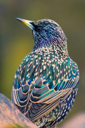

08:37:31.50 LOG:
08:37:31.50 .... file = Path('forest_or_bird/forest/490350ad-8754-4078-87ce-53290c21f911.jpg')


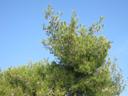

In [ ]:
randomdisplay(bird/'bird')
randomdisplay(bird/'forest')

08:37:31.54 LOG:
08:37:31.54 .... file = Path('T-rex_or_Spinosaurus aegyptiacus/Spinosaurus aegyptiacus/9c288562-6d7e-4de0-a906-d9005d67a638.jpg')


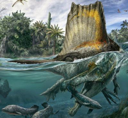

In [ ]:
randomdisplay(dino/"Spinosaurus aegyptiacus")

08:37:31.56 LOG:
08:37:31.56 .... file = Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/9173db81-4a84-4b77-bb18-20401568a38b.jpg')


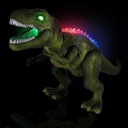

In [ ]:
randomdisplay(dino/"T-rex")

08:37:31.59 LOG:
08:37:31.59 .... file = Path('T-rex_or_Brachiosaurus/T-rex/6199ff55-566a-4455-9af4-ba4f2a5646fb.jpg')


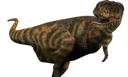

In [ ]:
randomdisplay(cry_dino/"T-rex")

### file_type, file_exts, and n_max in Path.ls
to list all the files inside the path

use file_type = 'binary' to find folders, images, videos; use file_type = 'text' to find `.py` and `.ipynb` files

use n_max=10 if you just want to list out 10 files or items

In [ ]:
dino.ls(file_type="text")
dino.ls(file_type="binary")

(#0) []

(#5) [Path('T-rex_or_Spinosaurus aegyptiacus/.DS_Store'),Path('T-rex_or_Spinosaurus aegyptiacus/crying'),Path('T-rex_or_Spinosaurus aegyptiacus/Spinosaurus aegyptiacus'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex'),Path('T-rex_or_Spinosaurus aegyptiacus/fierce')]

In [ ]:
(dino/"T-rex").ls(file_type='text')
(dino/"T-rex").ls(file_type='binary')

(#0) []

(#84) [Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/18db90d6-0eb4-4984-ac8a-5aa0b6aeacaa.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/d3439a0d-ce83-44cd-84f6-b4ae6fa77325.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/4893685a-1bb9-4682-aea1-8edcf29469ed.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/829089df-e243-4040-a737-1adb5bf97038.JPG'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/714950c2-022b-4491-9503-22e4310891fc.png'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/01fabe7c-fe23-4a69-b7e3-63ac58e4e9f7.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/04d675f3-addf-49ae-b4fe-894d35df12bb.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/fdafea87-586a-4c6f-a3af-e426f2aae178.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/8b6c67c9-8d82-48df-9ad7-59f8d14578f4.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/T-rex/b0bdc9ee-0d95-4495-93db-80429f2ef388.jpg')...]

### check_subfolders_img(path)
check all subfolders for images and print out the number of images they have recursively

In [ ]:
check_subfolders_img(dino)
check_subfolders_img(bird)
check_subfolders_img(cry_dino)

/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  crying
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  Spinosaurus aegyptiacus
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  T-rex
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  fierce
addup num: 330
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 170  forest
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 79  bird
addup num: 249
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Brachiosaurus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Brachiosaurus: 174  T-rex
/Users/Natsume/Documents/

In [ ]:
# list(dino.parent.absolute().ls())
dino.parent.absolute().parent
check_subfolders_img(dino.parent.absolute().parent)

Path('/Users/Natsume/Documents/fastdebug/nbs')

/Users/Natsume/Documents/fastdebug/nbs/_quarto.yml
/Users/Natsume/Documents/fastdebug/nbs/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/sidebar.yml
/Users/Natsume/Documents/fastdebug/nbs/styles.css
/Users/Natsume/Documents/fastdebug/nbs/.last_checked
/Users/Natsume/Documents/fastdebug/nbs/nbdev.yml
/Users/Natsume/Documents/fastdebug/nbs/index.ipynb
/Users/Natsume/Documents/fastdebug/nbs/Interesting_fastai/0001_The_origin_of_APL .ipynb
/Users/Natsume/Documents/fastdebug/nbs/Interesting_fastai/Interesting_things_fastai.ipynb
addup num: 0
/Users/Natsume/Documents/fastdebug/nbs/Math/math_0002_calculus.ipynb
/Users/Natsume/Documents/fastdebug/nbs/Math/math_0001_highschool.ipynb
/Users/Natsume/Documents/fastdebug/nbs/Math/sympy1.ipynb
/Users/Natsume/Documents/fastdebug/nbs/Math/line.png
addup num: 0
/Users/Natsume/Documents/fastdebug/nbs/lib/src_fastai_001a_losses.ipynb
/Users/Natsume/Documents/fastdebug/nbs/lib/00_core.ipynb
/Users/Natsume/Documents/fastdebug/nbs/lib/_quarto.yml
/Users/N

### verify_image(fn)
Confirm that `fn` can be opened

In [ ]:
# @snoop
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try: # if any of the following three lines cause error, we consider it as can't be opened
        im = Image.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try:
        im = Image.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
L(1,2,3), L([1,2,3])

((#3) [1,2,3], (#3) [1,2,3])

### verify_images(fns)
Find images in `fns` that can't be opened. using parallel, to applies `verify_image` in parallel to `fns`, using `n_workers=8`"

In [ ]:
#| export utils
# @snoop
def verify_images(fns):
    "Find images in `fns` that can't be opened. using parallel, to applies `verify_image` in parallel to `fns`, using `n_workers=8`"
#     return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
    lst = []
    for i,o in enumerate(parallel(verify_image, fns)):
        if not o:
            lst.append(fns[i])
    return L(lst)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
#| export utils
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/utils.py
# Type:      function

In [ ]:
doc(verify_images)

### remove_failed(path)
find all images inside a path which can't be opened and unlink them

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
#| export utils
def remove_failed(path):
    print("before running remove_failed:")
    check_subfolders_img(path)
    failed = verify_images(get_image_files(path))
    print(f"total num: {len(get_image_files(path))}")
    print(f"num offailed: {len(failed)}")
    failed.map(Path.unlink)
    print()
    print("after running remove_failed:")
    check_subfolders_img(path)

In [ ]:
remove_failed(dino)

before running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  crying
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  Spinosaurus aegyptiacus
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  T-rex
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  fierce
addup num: 330
total num: 331
num offailed: 0

after running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  crying
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  Spinosaurus aegyptiacus
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T

In [ ]:
remove_failed(bird)
remove_failed(cry_dino)

before running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 170  forest
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 79  bird
addup num: 249
total num: 251
num offailed: 0

after running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 170  forest
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 79  bird
addup num: 249
before running remove_failed:
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Brachiosaurus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Brachiosaurus: 174  T-rex
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Brachiosaurus: 111  Brachiosaurus
addup num: 285
total num: 285
num offailed: 9

after running remove_failed:
/U

In [ ]:
# dino.name
# dino.root
# dino.home()
# dino.is_dir()
# dino.is_file()
# dino.exists() 
# dino.is_absolute()
# dino.absolute()
# # dino.BASE_PATH

In [ ]:
# fastnbs("path.ls file_type")

In [ ]:
cry_dino.ls()[0]

Path('T-rex_or_Brachiosaurus/.DS_Store')

09:34:52.43 LOG:
09:34:52.44 .... file = Path('T-rex_or_Brachiosaurus/T-rex/f6caab8b-001e-4084-bc99-e7e304b3efe3.jpg')


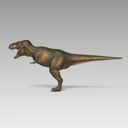

In [ ]:
randomdisplay(cry_dino.ls()[1])

08:37:33.49 LOG:
08:37:33.49 .... file = Path('T-rex_or_Brachiosaurus/Brachiosaurus/4a93e90f-96df-49e2-aa08-82fecdbcd750.jpg')


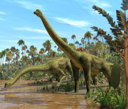

In [ ]:
randomdisplay(cry_dino.ls()[2])

### Path.unlink(self, missing_ok=False)
Remove this file or link.

If the path is a directory, use rmdir() instead.

If a file is not found, error will be raised


## How to create a DataLoaders with DataBlock and display a batch
To train a model, we'll need DataLoaders:     

1) a training set (the images used to create a model) and 

2) a validation set (the images used to check the accuracy of a model -- not used during training). 

We can view sample images from it:

### get_image_files, get_files, image_extensions
to extract all image files recursively from all subfolders of a parent path

In [ ]:
from fastai.data.transforms import _get_files

In [ ]:
not None

True

In [ ]:
def _get_files(p, # path
               fs, # list of filenames
               extensions=None):
    "get the fullnames for the list of filenames of a path"
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py

In [ ]:
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py

In [ ]:
from fastai.vision.all import *

In [ ]:
len(image_extensions)
".aspx" in image_extensions

65

False

In [ ]:
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py

In [ ]:
check_subfolders_img(dino)
get_image_files(dino)
check_subfolders_img(bird)
get_image_files(bird)

/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  crying
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  Spinosaurus aegyptiacus
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 83  T-rex
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/T-rex_or_Spinosaurus aegyptiacus: 82  fierce
addup num: 330


(#331) [Path('T-rex_or_Spinosaurus aegyptiacus/crying/c4016dd8-bde7-4dd4-b2b0-a9a4514ac834.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/20591e18-54dd-49e7-b00c-722dbd8872ab.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/553f845b-c5d9-4d10-94ac-9230da42b866.png'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/6c8a2034-8d0c-4935-a5af-7cb73dd75b63.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/481399dc-7dc5-4f20-b651-bf29e1085611.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/d19616c2-bf32-448a-879a-b409732b1cdb.png'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/2a4e59cd-511f-4a70-a5e4-26998160031a.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/9d2c2803-1403-4e0f-ab37-b16015d506db.jpg'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/c176c0f3-c4b5-42e6-ab52-5a4fc8b4d766.png'),Path('T-rex_or_Spinosaurus aegyptiacus/crying/b806226d-287c-46ec-9a0c-882ea3be438c.jpg')...]

/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird/.DS_Store
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 170  forest
/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird: 79  bird
addup num: 249


(#251) [Path('forest_or_bird/forest/82e9179d-2dd6-4144-8f66-891533ec6467.jpg'),Path('forest_or_bird/forest/6e84b01f-c9a3-466b-b0eb-527ea360d517.jpg'),Path('forest_or_bird/forest/c929266f-7495-434f-bd07-0b1a1d4a9051.jpg'),Path('forest_or_bird/forest/3601c5f2-dc4a-4e56-ada4-58943c0190b3.jpg'),Path('forest_or_bird/forest/eec11827-0f51-429d-84f0-84b3c24c2e1b.JPG'),Path('forest_or_bird/forest/f1742fe6-770d-45b7-a14f-d35ec8514704.jpg'),Path('forest_or_bird/forest/4dd1840a-1a62-43b0-acdc-de476c881e4a.jpg'),Path('forest_or_bird/forest/beb09236-e6d9-49eb-a522-f8c2e9d3ffb3.jpeg'),Path('forest_or_bird/forest/ea756b81-0e41-4554-830b-858fef1e2275.jpg'),Path('forest_or_bird/forest/16ffe691-aa2d-493e-8f1c-1dea9db419e4.jpg')...]

### ht: data - check the sizes of all images

In [ ]:
check_sizes_img(get_image_files(dino))

(400, 400)    69
(400, 225)    35
(400, 266)    23
(400, 300)    19
(266, 400)     6
              ..
(400, 239)     1
(400, 156)     1
(400, 229)     1
(400, 258)     1
(400, 271)     1
Length: 136, dtype: int64

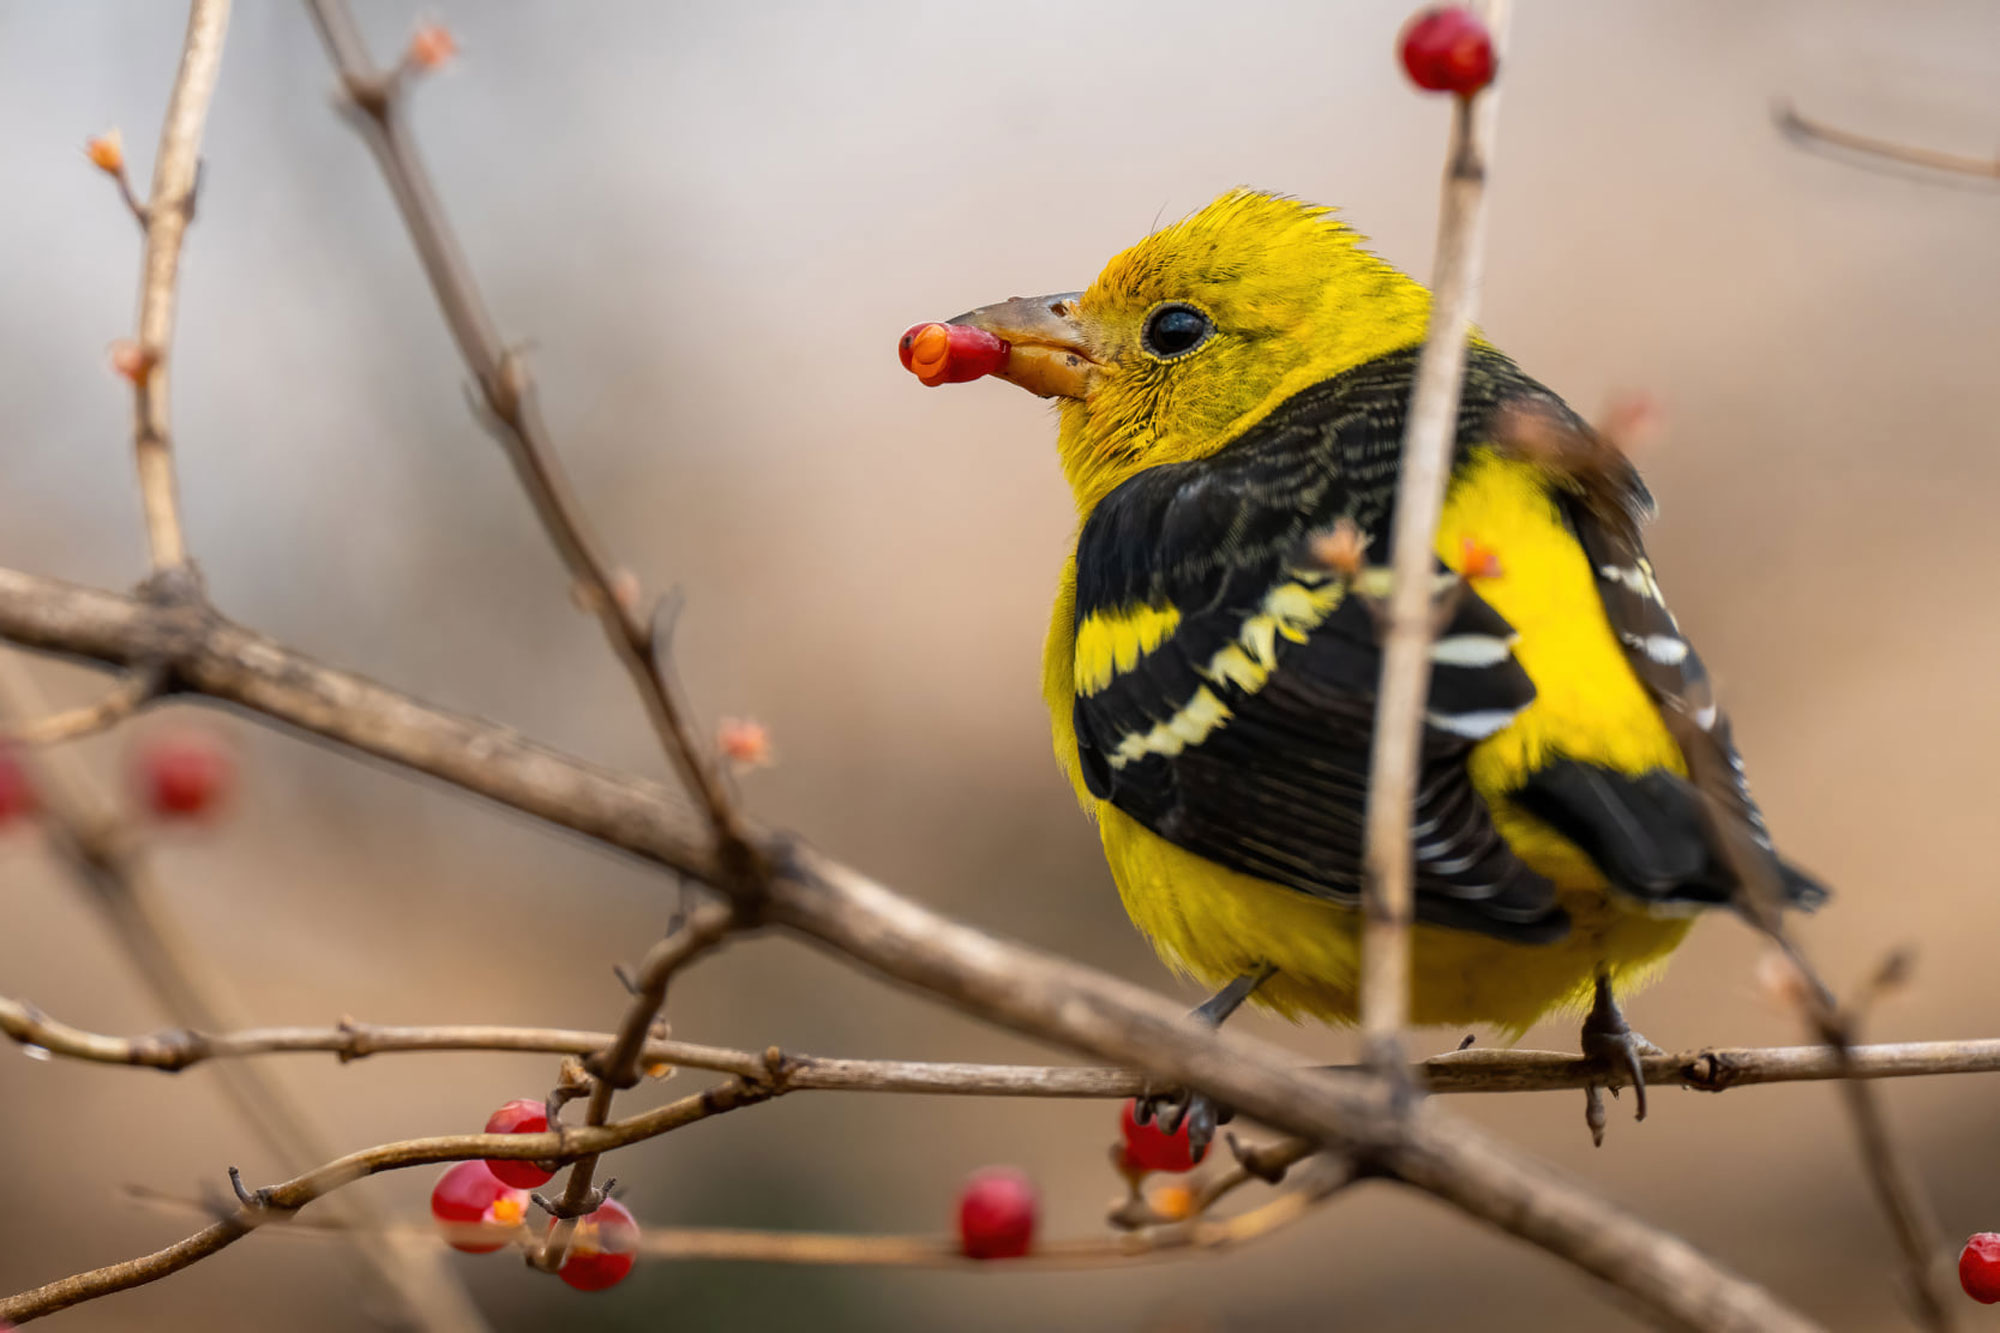

In [ ]:
Image.open(Path('forest_or_bird/bird/3b7a4112-9d77-4d8f-8b4c-a01e2ca1ecea.aspx'))

### parent_label(o)
extract the label from the filename's parent folder name

In [ ]:
def parent_label(o):
    "Label `item` with the parent folder name."
    return Path(o).parent.name
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py

In [ ]:
# dino.ls()[0].ls()[0]

In [ ]:
parent_label(dino.ls()[1].ls()[0])
parent_label(dino.ls()[2].ls()[0])

'crying'

'Spinosaurus aegyptiacus'

### RandomSplitter(valid_pct=0.2, seed=None), torch.linspace(0,1,100)
Create function that splits `items` between train/val with `valid_pct` randomly.

with seed=42, the random splits can be reproduced

In [ ]:
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/transforms.py

In [ ]:
x = torch.linspace(0, 1, 100)

In [ ]:
rs = RandomSplitter()
rs(x)

((#80) [24,2,3,27,87,15,41,7,81,93...],
 (#20) [86,18,61,14,84,89,46,4,90,96...])

In [ ]:
rs = RandomSplitter(seed=42)
rs(x)

((#80) [89,86,18,40,5,38,9,82,83,43...],
 (#20) [42,96,62,98,46,95,60,24,78,16...])

### Resize(RandTransform)
Resize image to `size` using `method` such as 'crop', 'squish' and 'pad'

What does `crop`, `squish` and `pad` resize effects look like

`rsz = Resize(256, method='crop')` returns a func and use it to actually resize image as below

`rsz(img, split_idx=0)`

In [ ]:
doc(Resize)

In [ ]:
ResizeMethod.Crop
ResizeMethod.Squish
ResizeMethod.Pad

'crop'

'squish'

'pad'

In [ ]:
Resize(192, method='squish')

Resize -- {'size': (192, 192), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 

In [ ]:
Resize(220, method="crop")

Resize -- {'size': (220, 220), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 

<AxesSubplot:>

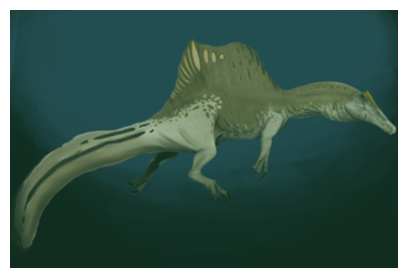

In [ ]:
dino_img = Path('T-rex_or_Spinosaurus aegyptiacus/Spinosaurus aegyptiacus/07b15395-ce8d-4250-a536-920159dfe57d.png')
img = PILImage(PILImage.create(dino_img).resize((600,400)))
show_image(img)

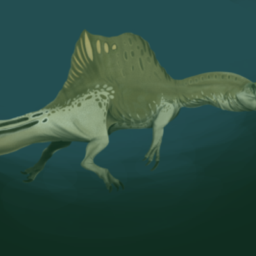

In [ ]:
rsz = Resize(256, method='crop')
rsz(img, split_idx=0)

<AxesSubplot:title={'center':'squish'}>

<AxesSubplot:title={'center':'pad'}>

<AxesSubplot:title={'center':'crop'}>

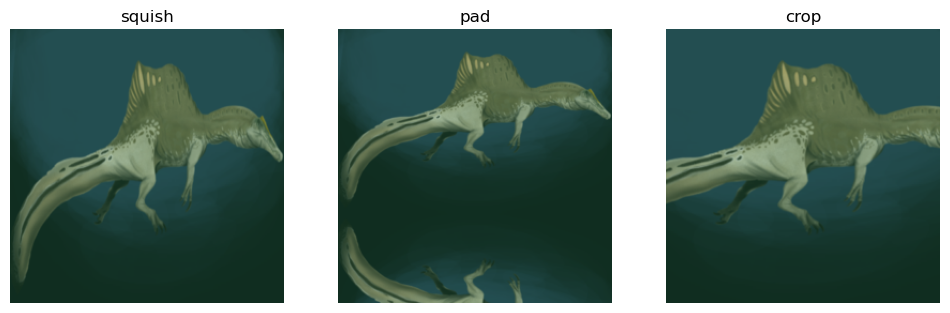

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=0), ctx=ax, title=method);

<AxesSubplot:title={'center':'squish'}>

<AxesSubplot:title={'center':'pad'}>

<AxesSubplot:title={'center':'crop'}>

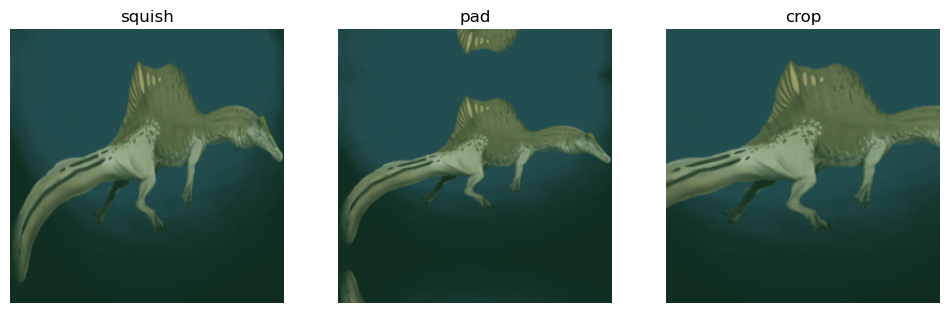

In [ ]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method)
    show_image(rsz(img, split_idx=1), ctx=ax, title=method);

### Resize inherited from RandTransform...Transform
Read the comments I made in the 3 sources to get a basic understanding of what they do

`Resize` class prepares args, `before_call` func, `encodes` func which is to crop and pad images

`RandomTransform` class prepares args, define `before_call` func for the first time in history, override `__call__` so that `before_call` is called first before `Transform.__call__` is called

`Transform` class prepares all args (most original), defines `decodes` func for the first time and override `__call__` inherit from `TfmMeta`

In [ ]:
from __future__ import annotations
from fastai.vision.augment import _process_sz, _get_sz

In [ ]:
from fastcore.transform import _TfmMeta, _tfm_methods, _is_tfm_method, _get_name, _TfmDict

In [ ]:
Resize.mro()

[fastai.vision.augment.Resize,
 fastai.vision.augment.RandTransform,
 fastcore.transform.DisplayedTransform,
 fastcore.transform.Transform,
 object]

In [ ]:
@delegates()
class Resize(RandTransform):
    split_idx,mode,mode_mask,order = None,BILINEAR,NEAREST,1
    "Resize image to `size` using `method`"
#     @snoop
    def __init__(self, 
        size:int|tuple, # Size to resize to, duplicated if one value is specified
        method:ResizeMethod=ResizeMethod.Crop, # A `ResizeMethod`
        pad_mode:PadMode=PadMode.Reflection, # A `PadMode`
        resamples=(BILINEAR, NEAREST), # Pillow `Image` resamples mode, resamples[1] for mask
        **kwargs
    ):
        "set up size into a tuple, put all attrs into self, run initialization from RandTransform, set up mode and mode_mask"
        size = _process_sz(size)
        store_attr()
#         pp(self)
        super().__init__(**kwargs)
        self.mode,self.mode_mask = resamples

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset
    ):
        "override before_call from RandomTransform.before_call"
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (random.random(),random.random())

#     @snoop
    def encodes(self, x:Image.Image|TensorBBox|TensorPoint):
        "Preparing all the args for running x.crop_pad function"
        orig_sz = _get_sz(x)
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, fastuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = fastuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

### what inside x.crop_pad from the last line of code above?
# im._do_crop_pad?? # use x.crop and tvpad on x, finally run x.resize
# img.crop_pad?? # prepare all args for running im._do_crop_pad

# File:           ~/mambaforge/lib/python3.9/site-packages/fastai/vision/augment.py

In [ ]:
class RandTransform(DisplayedTransform):
    "A transform that before_call its state at each `__call__`"
    do,nm,supports,split_idx = True,None,[],0
    def __init__(self, 
        p:float=1., # Probability of applying Transform
        nm:str=None,
        before_call:callable=None, # Optional batchwise preprocessing function
        **kwargs
    ):
        "prepare attr p, run Transform.__init__ to prepare other args, and prepare `before_call` func"
        store_attr('p')
        super().__init__(**kwargs)
        self.before_call = ifnone(before_call,self.before_call)

    def before_call(self, 
        b, 
        split_idx:int, # Index of the train/valid dataset
    ):
        "Define the before_call function. This function can be overridden. Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p

    def __call__(self, 
        b, 
        split_idx:int=None, # Index of the train/valid dataset
        **kwargs
    ):
        "override Transform.__call__ by calling self.before_call before Transform.__call__"
        self.before_call(b, split_idx=split_idx)
        return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b
# File:           ~/mambaforge/lib/python3.9/site-packages/fastai/vision/augment.py
# Type:           _TfmMeta
# Subclasses:     FlipItem, DihedralItem, RandomCrop, Resize, RandomResizedCrop, AffineCoordTfm, RandomResizedCropGPU, SpaceTfm, RandomErasing, Resize, ...


In [ ]:
class Transform(metaclass=_TfmMeta):
    "Delegates (`__call__`,`decode`,`setup`) to (<code>encodes</code>,<code>decodes</code>,<code>setups</code>) if `split_idx` matches"
    split_idx,init_enc,order,train_setup = None,None,0,None
#     @snoop
    def __init__(self, enc=None, dec=None, split_idx=None, order=None):
        "prepares self.split_idx, self.order, self.init_enc, self.encodes, self.decodes"
        self.split_idx = ifnone(split_idx, self.split_idx)
        if order is not None: self.order=order
        self.init_enc = enc or dec
        if not self.init_enc: return

        self.encodes,self.decodes,self.setups = TypeDispatch(),TypeDispatch(),TypeDispatch()
        if enc:
            self.encodes.add(enc)
            self.order = getattr(enc,'order',self.order)
            if len(type_hints(enc)) > 0: self.input_types = union2tuple(first(type_hints(enc).values()))
            self._name = _get_name(enc)
        if dec: self.decodes.add(dec)

    @property
    def name(self): return getattr(self, '_name', _get_name(self))
    def __call__(self, x, **kwargs): 
        "run self.encodes(x)"
        return self._call('encodes', x, **kwargs)
    def decode  (self, x, **kwargs): 
        "run self.decodes(x)"
        return self._call('decodes', x, **kwargs)
    def __repr__(self): return f'{self.name}:\nencodes: {self.encodes}decodes: {self.decodes}'

    def setup(self, items=None, train_setup=False):
        train_setup = train_setup if self.train_setup is None else self.train_setup
        return self.setups(getattr(items, 'train', items) if train_setup else items)

    def _call(self, fn, x, split_idx=None, **kwargs):
        "run fn(x) or return x based on split_idx"
        if split_idx!=self.split_idx and self.split_idx is not None: return x
        return self._do_call(getattr(self, fn), x, **kwargs)

    def _do_call(self, f, x, **kwargs):
        "run f(x) and make result the same type as x"
        if not _is_tuple(x):
            if f is None: return x
            ret = f.returns(x) if hasattr(f,'returns') else None
            return retain_type(f(x, **kwargs), x, ret)
        res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
        return retain_type(res, x)
# File:           ~/mambaforge/lib/python3.9/site-packages/fastcore/transform.py
# Type:           _TfmMeta
# Subclasses:     InplaceTransform, DisplayedTransform, ItemTransform, ToTensor, AddMaskCodes, PointScaler, BBoxLabeler

In [ ]:
Transform.__dict__

mappingproxy({'__module__': '__main__',
              '__doc__': 'Delegates (`__call__`,`decode`,`setup`) to (<code>encodes</code>,<code>decodes</code>,<code>setups</code>) if `split_idx` matches',
              'split_idx': None,
              'init_enc': None,
              'order': 0,
              'train_setup': None,
              '__init__': <function __main__.Transform.__init__(self, enc=None, dec=None, split_idx=None, order=None)>,
              'name': <property>,
              '__call__': <function __main__.Transform.__call__(self, x, **kwargs)>,
              'decode': <function __main__.Transform.decode(self, x, **kwargs)>,
              '__repr__': <function __main__.Transform.__repr__(self)>,
              'setup': <function __main__.Transform.setup(self, items=None, train_setup=False)>,
              '_call': <function __main__.Transform._call(self, fn, x, split_idx=None, **kwargs)>,
              '_do_call': <function __main__.Transform._do_call(self, f, x, **kwargs)>,


In [ ]:
_tfm_methods

('encodes', 'decodes', 'setups')

### how Transform created by TfmMeta
see how TfmMeta is at work when Transform is created as a class

In [ ]:
class _TfmMeta(type):
    @snoop
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        for nm in _tfm_methods:
            base_td = [getattr(b,nm,None) for b in bases]
            if nm in res.__dict__: getattr(res,nm).bases = base_td
            else: setattr(res, nm, TypeDispatch(bases=base_td))
        # _TfmMeta.__call__ shadows the signature of inheriting classes, set it back
        res.__signature__ = inspect.signature(res.__init__)
        return res


    def __call__(cls, *args, **kwargs):
        "if no tfm_method given, just return type.__call__ as everyone else; otherwise, store the tfm func in Transform class and return it"
        f = first(args)
        n = getattr(f, '__name__', None)
        if _is_tfm_method(n, f):
            getattr(cls,n).add(f)
            return f
        obj = super().__call__(*args, **kwargs)
        # _TfmMeta.__new__ replaces cls.__signature__ which breaks the signature of a callable
        # instances of cls, fix it
        if hasattr(obj, '__call__'): obj.__signature__ = inspect.signature(obj.__call__)
        return obj

    @classmethod
    def __prepare__(cls, name, bases): return _TfmDict()
# File:           ~/mambaforge/lib/python3.9/site-packages/fastcore/transform.py
# Type:           type
# Subclasses:     

In [ ]:
class Transform(metaclass=_TfmMeta):pass

22:58:20.95 >>> Call to _TfmMeta.__new__ in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/2173750754.py", line 3
22:58:20.95 .......... cls = <class '__main__._TfmMeta'>
22:58:20.95 .......... name = 'Transform'
22:58:20.95 .......... bases = ()
22:58:20.95 .......... dict = {'__module__': '__main__', '__qualname__': 'Transform'}
22:58:20.95 .......... __class__ = <class '__main__._TfmMeta'>
22:58:20.95    3 |     def __new__(cls, name, bases, dict):
22:58:20.95    4 |         res = super().__new__(cls, name, bases, dict)
22:58:20.95 .............. res = <class '__main__.Transform'>
22:58:20.95    5 |         for nm in _tfm_methods:
22:58:20.95 .............. nm = 'encodes'
22:58:20.95    6 |             base_td = [getattr(b,nm,None) for b in bases]
    22:58:20.95 List comprehension:
    22:58:20.95    6 |             base_td = [getattr(b,nm,None) for b in bases]
    22:58:20.95 .................. Iterating over <tuple_iterator object>
    22:58:20.95 ........

In [ ]:
Transform.__dict__

mappingproxy({'__module__': '__main__',
              '__dict__': <attribute '__dict__' of 'Transform' objects>,
              '__weakref__': <attribute '__weakref__' of 'Transform' objects>,
              '__doc__': None,
              'encodes': ,
              'decodes': ,
              'setups': ,
              '__signature__': <Signature (self, /, *args, **kwargs)>})

In [ ]:
from fastcore.transform import _TfmMeta
# _TfmMeta??

In [ ]:
class _TfmMeta(type):
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        for nm in _tfm_methods:
            base_td = [getattr(b,nm,None) for b in bases]
            if nm in res.__dict__: getattr(res,nm).bases = base_td
            else: setattr(res, nm, TypeDispatch(bases=base_td))
        # _TfmMeta.__call__ shadows the signature of inheriting classes, set it back
        res.__signature__ = inspect.signature(res.__init__)
        return res

    def __call__(cls, *args, **kwargs):
        f = first(args)
        n = getattr(f, '__name__', None)
        if _is_tfm_method(n, f):
            getattr(cls,n).add(f)
            return f
        obj = super().__call__(*args, **kwargs)
        # _TfmMeta.__new__ replaces cls.__signature__ which breaks the signature of a callable
        # instances of cls, fix it
        if hasattr(obj, '__call__'): obj.__signature__ = inspect.signature(obj.__call__)
        return obj

    @classmethod
    def __prepare__(cls, name, bases): return _TfmDict()
# File:           ~/mambaforge/lib/python3.9/site-packages/fastcore/transform.py
# Type:           type

### ImageBlock(cls:PILBase=PILImage) and TransformBlock()
to create an instance of `TransformBlock`, which is passed to DataBlock and dataloaders for use later

set `PILImage.create` as `type_tfms`, and `IntToFloatTensor` as `batch_tfms` for this `TransformBlock`

A `TransformBlock` is just an object/container which stores a particular set of transform functions such as type_tfms, item_tfms, batch_tfms, 

and also store specific properties or args like dl_type, dls_kwargs

In [ ]:
def ImageBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/data.py
# Type:      function

In [ ]:
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, 
        type_tfms:list=None, # One or more `Transform`s
        item_tfms:list=None, # `ItemTransform`s, applied on an item
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch
        dl_type:TfmdDL=None, # Task specific `TfmdDL`, defaults to `TfmdDL`
        dls_kwargs:dict=None, # Additional arguments to be passed to `DataLoaders`
    ):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)
# File:           ~/mambaforge/lib/python3.9/site-packages/fastai/data/block.py
# Type:           type
# Subclasses: 

### CategoryBlock(vocab: 'list | pd.Series' = None, sort: 'bool' = True, add_na: 'bool' = False)
to create an instance of `TransformBlock`, which is passed to DataBlock and dataloaders for use later

set an instance of Categorize i.e., `Categorize(vocab=vocab, sort=sort, add_na=add_na)` as `type_tfms` for this `TransformBlock`

A `TransformBlock` is just an object/container which stores a particular set of transform functions such as type_tfms, item_tfms, batch_tfms, 

and also store specific properties or args like dl_type, dls_kwargs

In [ ]:
def CategoryBlock(
    vocab:list|pd.Series=None, # List of unique class names
    sort:bool=True, # Sort the classes alphabetically
    add_na:bool=False, # Add `#na#` to `vocab`
):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, sort=sort, add_na=add_na))
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/data/block.py
# Type:      function

### DataBlock.__init__(blocks:list=None, dl_type:TfmdDL=None, getters:list=None, n_inp:int=None, item_tfms:list=None, batch_tfms:list=None, get_items=None, splitter=None, get_y=None, get_x=None)
Prepare and organise all the funcs needed to split and transform x and getting y or labels

In [ ]:
# fastnbs("ImageBlock")
# fastnbs("funcs_kwargs")

In [ ]:
from fastai.data.block import  _merge_tfms, _merge_grouper

In [ ]:
@docs
@funcs_kwargs # it is working with _methods to add more args to __init__ method below
class DataBlock():
    "Generic container to quickly build `Datasets` and `DataLoaders`."
    get_x=get_items=splitter=get_y = None # class properties
    blocks,dl_type = (TransformBlock,TransformBlock),TfmdDL 
    
    _methods = 'get_items splitter get_y get_x'.split() # so that __init__ args will include get_items, splitter, get_y, get_x
    
    _msg = "If you wanted to compose several transforms in your getter don't forget to wrap them in a `Pipeline`."
    
    @snoop
    def __init__(self, 
        blocks:list=None, # One or more `TransformBlock`s, e.g., ImageBlock, CategoryBlock
        dl_type:TfmdDL=None, # Task specific `TfmdDL`, defaults to `block`'s dl_type or`TfmdDL`
        getters:list=None, # Getter functions applied to results of `get_items`
        n_inp:int=None, # Number of inputs
        item_tfms:list=None, # `ItemTransform`s, applied on an item 
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch
        **kwargs, 
    ):
        "Prepare and organise all the funcs needed to split and transform x and getting y or labels"
        blocks = L(self.blocks if blocks is None else blocks)
        pp(blocks)
        blocks = L(b() if callable(b) else b for b in blocks)
        pp(blocks)        
        
        pp(inspect.getdoc(blocks.attrgot), inspect.signature(blocks.attrgot))
        pp(blocks.map(lambda x: x.__dict__))
        self.type_tfms = blocks.attrgot('type_tfms', L())
           
        pp(inspect.getdoc(_merge_tfms), inspect.signature(_merge_tfms))
        self.default_item_tfms  = _merge_tfms(*blocks.attrgot('item_tfms',  L()))
        pp(self.default_item_tfms)
        
        self.default_batch_tfms = _merge_tfms(*blocks.attrgot('batch_tfms', L()))
        pp(self.default_batch_tfms)
        
        for b in blocks:
            if getattr(b, 'dl_type', None) is not None: 
                self.dl_type = pp(b.dl_type)
        if dl_type is not None: 
            self.dl_type = pp(dl_type)
        pp(self.dl_type)
            
        self.dataloaders = delegates(self.dl_type.__init__)(self.dataloaders) # get kwargs from dl_type.__init__ to self.dataloaders
        pp(self.dataloaders)
        
        self.dls_kwargs = merge(*blocks.attrgot('dls_kwargs', {}))
        pp(self.dls_kwargs)

        self.n_inp = ifnone(n_inp, max(1, len(blocks)-1)) # n_inp is dependent on the number of blocks
        pp(self.n_inp)
        
        self.getters = ifnone(getters, [noop]*len(self.type_tfms))
        pp(self.getters)
        
        if self.get_x:
            if len(L(self.get_x)) != self.n_inp:
                raise ValueError(f'get_x contains {len(L(self.get_x))} functions, but must contain {self.n_inp} (one for each input)\n{self._msg}')
            self.getters[:self.n_inp] = L(self.get_x)
        pp(self.get_x)
            
        if self.get_y:
            n_targs = len(self.getters) - self.n_inp
            if len(L(self.get_y)) != n_targs:
                raise ValueError(f'get_y contains {len(L(self.get_y))} functions, but must contain {n_targs} (one for each target)\n{self._msg}')
            self.getters[self.n_inp:] = L(self.get_y)
        pp(self.getters)

        if kwargs: 
            raise TypeError(f'invalid keyword arguments: {", ".join(kwargs.keys())}')
        
        pp(item_tfms, batch_tfms)
        pp(inspect.getdoc(self.new), inspect.signature(self.new))
        self.new(item_tfms, batch_tfms)

    def _combine_type_tfms(self): return L([self.getters, self.type_tfms]).map_zip(
        lambda g,tt: (g.fs if isinstance(g, Pipeline) else L(g)) + tt)

    def new(self, 
        item_tfms:list=None, # `ItemTransform`s, applied on an item
        batch_tfms:list=None, # `Transform`s or `RandTransform`s, applied by batch 
    ):
        self.item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        self.batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return self

    @classmethod
    def from_columns(cls, 
        blocks:list =None, # One or more `TransformBlock`s
        getters:list =None, # Getter functions applied to results of `get_items`
        get_items:callable=None, # A function to get items
        **kwargs,
    ):
        if getters is None: getters = L(ItemGetter(i) for i in range(2 if blocks is None else len(L(blocks))))
        get_items = _zip if get_items is None else compose(get_items, _zip)
        return cls(blocks=blocks, getters=getters, get_items=get_items, **kwargs)

    def datasets(self, 
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)

    def dataloaders(self, 
        source, # The data source
        path:str='.', # Data source and default `Learner` path 
        verbose:bool=False, # Show verbose messages
        **kwargs
    ) -> DataLoaders:
        dsets = self.datasets(source, verbose=verbose)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

    _docs = dict(new="Create a new `DataBlock` with other `item_tfms` and `batch_tfms`",
                 datasets="Create a `Datasets` object from `source`",
                 dataloaders="Create a `DataLoaders` object from `source`")
# File:           ~/mambaforge/lib/python3.9/site-packages/fastai/data/block.py
# Type:           type

In [ ]:
#|eval: false
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(bird)

22:58:24.90 >>> Call to DataBlock.__init__ in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/1228990494.py", line 13
22:58:24.90 .......... self = <__main__.DataBlock object>
22:58:24.90 .......... blocks = (<function ImageBlock>, <function CategoryBlock>)
22:58:24.90 .......... dl_type = None
22:58:24.90 .......... getters = None
22:58:24.90 .......... n_inp = None
22:58:24.90 .......... item_tfms = [Resize -- {'size': (192, 192), 'method': 'squish...encodes
22:58:24.90                        (TensorPoint,object) -> encodes
22:58:24.90                        decodes: ]
22:58:24.90 .......... batch_tfms = None
22:58:24.90 .......... kwargs = {}
22:58:24.90   13 |     def __init__(self, 
22:58:24.90   23 |         blocks = L(self.blocks if blocks is None else blocks)
22:58:24.90 .............. blocks = [<function ImageBlock>, <function CategoryBlock>]
22:58:24.90   24 |         pp(blocks)
22:58:24.90 LOG:
22:58:24.96 .... blocks = [<function ImageBlock>, <functio

### DataBlock.datasets(source, verbose)
get data items from the source, and split the items and use `fastai.data.core.Datasets` to create the datasets

In [ ]:
# DataBlock.dataloaders??
# from fastdebug.utils import *
# chk

In [ ]:
from fastai.vision.all import DataBlock # so that @snoop and pp can remain inside the DataBlock.__init__ source code

In [ ]:
@patch
@snoop
def datasets(self:DataBlock, 
        source, # The data source
        verbose:bool=False, # Show verbose messages
    ) -> Datasets:
        self.source = source 
        
        pp(doc_sig(pv))
        pv(f"Collecting items from {source}", verbose)
        pp(pv(f"Collecting items from {source}", verbose))
        
        pp((None or noop))
        pp((self.get_items or noop))
        items = (self.get_items or noop)(source)
        pp(chk(items))  
        
        pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        pp(chk(splits))
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        
        pp(doc_sig(Datasets))
        pp(doc_sig(Datasets.__init__))
        res = Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
        return res

In [ ]:
#|eval: false
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).datasets(bird, True)

22:58:32.54 >>> Call to datasets in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/3647961006.py", line 3
22:58:32.54 ...... self = <fastai.data.block.DataBlock object>
22:58:32.54 ...... source = Path('forest_or_bird')
22:58:32.54 ...... verbose = True
22:58:32.54    3 | def datasets(self:DataBlock, 
22:58:32.54    7 |         self.source = source 
22:58:32.54    9 |         pp(doc_sig(pv))
22:58:32.55 LOG:
22:58:32.56 .... doc_sig(pv) = ('no mro', 'no doc', <Signature (text, verbose)>)
22:58:32.56   10 |         pv(f"Collecting items from {source}", verbose)
22:58:32.56   11 |         pp(pv(f"Collecting items from {source}", verbose))
22:58:32.57 LOG:
22:58:32.57 .... pv(f"Collecting items from {source}", verbose) = None
22:58:32.57   13 |         pp((None or noop))
22:58:32.57 LOG:
22:58:32.58 .... None or noop = <function noop>
22:58:32.58   14 |         pp((self.get_items or noop))
22:58:32.58 LOG:
22:58:32.58 .... self.get_items or noop = <function get_ima

Found 251 items
2 datasets of sizes 201,50
Setting up Pipeline: PILBase.create


22:58:32.89 .............. res = (#251) [(PILImage mode=RGB size=400x250, TensorC...age mode=RGB size=400x400, TensorCategory(1))...]
22:58:32.89   26 |         return res


Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


22:58:33.04 <<< Return value from datasets: (#251) [(PILImage mode=RGB size=400x250, TensorC...age mode=RGB size=400x400, TensorCategory(1))...]


In [ ]:
@patch
def datasets(self:DataBlock, 
    source, # The data source
    verbose:bool=False, # Show verbose messages
) -> Datasets:
    self.source = source                     ; pv(f"Collecting items from {source}", verbose)
    items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
    splits = (self.splitter or RandomSplitter())(items)
    pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
    return Datasets(items, tfms=self._combine_type_tfms(), splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)

### DataBlock.dataloaders
use `DataBlock.datasets(source, verbose=verbose)` to create a ```fastai.data.core.Datasets``` first and then use ```Datasets.dataloaders``` to create a ```fastai.data.core.DataLoaders```

In [ ]:
from fastai.vision.all import DataBlock # so that @snoop and pp can remain inside the DataBlock.__init__ source code

In [ ]:
@patch
@snoop
def dataloaders(self:DataBlock, 
    source, # The data source
    path:str='.', # Data source and default `Learner` path 
    verbose:bool=False, # Show verbose messages
    **kwargs
) -> DataLoaders:
    pp(doc_sig(self.datasets))
    
    dsets = self.datasets(source, verbose=verbose)
    pp(doc_sig(type(dsets)))
#     pp(inspect_class(dsets.__class__))
    
    kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
    pp(kwargs)
    
    pp(doc_sig(dsets.dataloaders))
    res = dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)
    pp(doc_sig(res))
    pp(doc_sig(res.__class__))
    return res

In [ ]:
#|eval: false
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(bird)

22:58:34.48 >>> Call to dataloaders in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/2346295921.py", line 3
22:58:34.48 ...... self = <fastai.data.block.DataBlock object>
22:58:34.48 ...... source = Path('forest_or_bird')
22:58:34.48 ...... path = '.'
22:58:34.48 ...... verbose = False
22:58:34.48 ...... kwargs = {}
22:58:34.48    3 | def dataloaders(self:DataBlock, 
22:58:34.48    9 |     pp(doc_sig(self.datasets))
22:58:34.49 LOG:
22:58:34.50 .... doc_sig(self.datasets) = ('no mro',
22:58:34.50                                'no doc',
22:58:34.50                                <Signature (source, verbose: 'bool' = False) -> 'Datasets'>)
22:58:34.50   11 |     dsets = self.datasets(source, verbose=verbose)
22:58:34.76 .......... dsets = (#251) [(PILImage mode=RGB size=400x250, TensorC...age mode=RGB size=400x400, TensorCategory(1))...]
22:58:34.76   12 |     pp(doc_sig(type(dsets)))
22:58:34.76 LOG:
22:58:34.77 .... doc_sig(type(dsets)) = ((<class 'fastai.data

In [ ]:
@patch # return dataloaders back to normal
def dataloaders(self:DataBlock, 
    source, # The data source
    path:str='.', # Data source and default `Learner` path 
    verbose:bool=False, # Show verbose messages
    **kwargs
) -> DataLoaders:
    dsets = self.datasets(source, verbose=verbose)
    kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
    return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms, **kwargs)

### vision_learner(dls, arch...)
Build a vision learner from `dls` and `arch`

A learner is a container to prepare model and args, and put model, dls, loss func together

In [ ]:
from fastai.vision.learner import *
from fastai.vision.learner import  _default_meta, _add_norm

In [ ]:
@snoop
@delegates(create_vision_model) 
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, 
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
        # model & head args
        cut=None, init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, pool=True,
        lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, **kwargs):
    "Build a vision learner from `dls` and `arch`"
    pp(doc_sig(get_c))
    if n_out is None: 
        n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    pp(arch, _default_meta, model_meta, model_meta.get)
    meta = model_meta.get(arch, _default_meta)
    model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                      first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
    pp(model_args)
    if isinstance(arch, str):
        model,cfg = create_timm_model(arch, n_out, default_split, pretrained, **model_args)
        pp(doc_sig(create_timm_model))
        pp(model, cfg)
        if normalize: 
            _timm_norm(dls, cfg, pretrained)
        pp(doc_sig(_timm_norm))
    else:
        pp(dls, meta, pretrained)
        pp(doc_sig(_add_norm))
        if normalize: 
            _add_norm(dls, meta, pretrained)
        pp(arch, n_out, pretrained, model_args)
        pp(doc_sig(create_vision_model))
        model = create_vision_model(arch, n_out, pretrained=pretrained, **model_args)
        pp(model)
    pp.deep(lambda: ifnone(splitter, meta['split']))
    splitter=ifnone(splitter, meta['split'])
    pp(dict(dls=dls, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms))
    pp(doc_sig(Learner))
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    pp(doc_sig(learn.freeze))
    if pretrained: 
        learn.freeze()
    # keep track of args for loggers
    pp(doc_sig(store_attr), kwargs)
    pp(learn.__dict__.keys())
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    pp(learn.__dict__.keys())
    return learn
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/learner.py
# Type:      function

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

22:58:37.46 >>> Call to vision_learner in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/3098971962.py", line 3
22:58:37.46 ...... dls = <fastai.data.core.DataLoaders object>
22:58:37.46 ...... arch = <function resnet18>
22:58:37.46 ...... normalize = True
22:58:37.46 ...... n_out = None
22:58:37.46 ...... pretrained = True
22:58:37.46 ...... loss_func = None
22:58:37.46 ...... opt_func = <function Adam>
22:58:37.46 ...... lr = 0.001
22:58:37.46 ...... splitter = None
22:58:37.46 ...... cbs = None
22:58:37.46 ...... metrics = <function error_rate>
22:58:37.46 ...... path = None
22:58:37.46 ...... model_dir = 'models'
22:58:37.46 ...... wd = None
22:58:37.46 ...... wd_bn_bias = False
22:58:37.46 ...... train_bn = True
22:58:37.46 ...... moms = (0.95, 0.85, 0.95)
22:58:37.46 ...... cut = None
22:58:37.46 ...... init = <function kaiming_normal_>
22:58:37.46 ...... custom_head = None
22:58:37.46 ...... concat_pool = True
22:58:37.46 ...... pool = True
22:58:37.46 ..

22:58:37.52 .... model_meta.get = <built-in method get of dict object>
22:58:37.52   16 |     meta = model_meta.get(arch, _default_meta)
22:58:37.52 .......... meta = {'cut': -2, 'split': <function _resnet_split>, 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}
22:58:37.52   17 |     model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
22:58:37.52   18 |                       first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
22:58:37.52   17 |     model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
22:58:37.53   18 |                       first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
22:58:37.53   17 |     model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
22:58:37.53 .......... model_args = {'init': <function kai

22:58:37.87   36 |     pp.deep(lambda: ifnone(splitter, meta['split']))
22:58:37.87 LOG:
22:58:37.91 ........ ifnone = <function ifnone>
22:58:37.91 ........ splitter = None
22:58:37.91 ............ meta = {'cut': -2, 'split': <function _resnet_split>, 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}
22:58:37.91 ........ meta['split'] = <function _resnet_split>
22:58:37.91 .... ifnone(splitter, meta['split']) = <function _resnet_split>
22:58:37.91   37 |     splitter=ifnone(splitter, meta['split'])
22:58:37.91 .......... splitter = <function _resnet_split>
22:58:37.91   38 |     pp(dict(dls=dls, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
22:58:37.91   39 |                    metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms))
22:58:37.91   38 |     pp(dict(dls=dls, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
22:58:37.92 LOG:
22:58:37.93 .... dict(dls=dls, los

In [ ]:
# the official source
@delegates(create_vision_model) 
def vision_learner(dls, arch, normalize=True, n_out=None, pretrained=True, 
        # learner args
        loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
        model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
        # model & head args
        cut=None, init=nn.init.kaiming_normal_, custom_head=None, concat_pool=True, pool=True,
        lin_ftrs=None, ps=0.5, first_bn=True, bn_final=False, lin_first=False, y_range=None, **kwargs):
    "Build a vision learner from `dls` and `arch`"
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    meta = model_meta.get(arch, _default_meta)
    model_args = dict(init=init, custom_head=custom_head, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                      first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range, **kwargs)
    if isinstance(arch, str):
        model,cfg = create_timm_model(arch, n_out, default_split, pretrained, **model_args)
        if normalize: _timm_norm(dls, cfg, pretrained)
    else:
        if normalize: _add_norm(dls, meta, pretrained)
        model = create_vision_model(arch, n_out, pretrained=pretrained, **model_args)
    
    splitter=ifnone(splitter, meta['split'])
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/vision/learner.py
# Type:      function

In [ ]:
learn.__dict__.keys()

dict_keys(['dls', 'model', '__stored_args__', 'loss_func', 'opt_func', 'lr', 'splitter', '_metrics', 'path', 'model_dir', 'wd', 'wd_bn_bias', 'train_bn', 'moms', 'default_cbs', 'training', 'create_mbar', 'logger', 'opt', 'cbs', 'train_eval', 'recorder', 'cast_to_tensor', 'progress', 'lock', 'n_epoch', 'arch', 'normalize', 'n_out', 'pretrained'])

### fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100...)
Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.

In [ ]:
@patch
@snoop
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    pp(doc_sig(self.freeze))
    self.freeze()
    pp(doc_sig(self.fit_one_cycle))
    pp(freeze_epochs, slice(base_lr), kwargs)
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    pp(doc_sig(self.unfreeze))
    self.unfreeze()
    pp(epochs, slice(base_lr/lr_mult, base_lr), pct_start, div, kwargs)
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/callback/schedule.py
# Type:      method

In [ ]:
learn.fine_tune(1)

22:58:40.65 >>> Call to fine_tune in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_89565/3127910192.py", line 4
22:58:40.65 ...... self = <fastai.learner.Learner object>
22:58:40.65 ...... epochs = 1
22:58:40.65 ...... base_lr = 0.002
22:58:40.65 ...... freeze_epochs = 1
22:58:40.65 ...... lr_mult = 100
22:58:40.65 ...... pct_start = 0.3
22:58:40.65 ...... div = 5.0
22:58:40.65 ...... kwargs = {}
22:58:40.65    4 | def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
22:58:40.65    7 |     pp(doc_sig(self.freeze))
22:58:40.65 LOG:
22:58:40.66 .... doc_sig(self.freeze) = ('no mro', 'Freeze up to last parameter group', <Signature ()>)
22:58:40.66    8 |     self.freeze()
22:58:40.66    9 |     pp(doc_sig(self.fit_one_cycle))
22:58:40.66 LOG:
22:58:40.67 .... doc_sig(self.fit_one_cycle) = ('no mro',
22:58:40.67                                     'Fit `self.model` for `n_epoch` using the 1cycle policy.',
22:58:40.67                            

22:58:48.04   12 |     base_lr /= 2
22:58:48.04 .......... base_lr = 0.001
22:58:48.04   13 |     pp(doc_sig(self.unfreeze))
22:58:48.05 LOG:
22:58:48.05 .... doc_sig(self.unfreeze) = ('no mro', 'Unfreeze the entire model', <Signature ()>)
22:58:48.05   14 |     self.unfreeze()
22:58:48.05   15 |     pp(epochs, slice(base_lr/lr_mult, base_lr), pct_start, div, kwargs)
22:58:48.05 LOG:
22:58:48.06 .... epochs = 1
22:58:48.06 .... slice(base_lr/lr_mult, base_lr) = slice(1e-05, 0.001, None)
22:58:48.06 .... pct_start = 0.3
22:58:48.06 .... div = 5.0
22:58:48.06 .... kwargs = {}
22:58:48.06   16 |     self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)


22:58:55.37 <<< Return value from fine_tune: None


In [ ]:
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/callback/schedule.py
# Type:      method

### CPU is fine and quick with small dataset like this one

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
#|eval: false
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [ ]:
# Path.unlink(Path('/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/forest_or_bird/bird/82a964e3-e3db-4f05-895a-27306fe11a71.jpg'))

### Learner.predict(self:Learner, item, rm_type_tfms=None, with_input=False)
use learner to predict on a single item, and return 3 things: target (eg., bird or forest), 0 or 1, prob of bird and prob of forest

In [ ]:
@patch
@snoop
def predict(self:Learner, item, rm_type_tfms=None, with_input=False):
    pp(doc_sig(self.dls.test_dl))
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    pp(doc_sig(self.get_preds))
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    if i==1:
        inp = (inp,) 
    else:
        inp = tuplify(inp)
    pp(doc_sig(self.dls.decode_batch))
    dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
    pp(doc_sig(tuplify), doc_sig(detuplify))
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: 
        res = (dec_inp,) + res
    return res
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/learner.py
# Type:      method

In [ ]:
randomdisplay(bird/"bird")

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create(Path('forest_or_bird/bird/fa32d017-01fc-4175-be53-16014ea7f683.jpg')))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

In [ ]:
@patch
def predict(self:Learner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res
# File:      ~/mambaforge/lib/python3.9/site-packages/fastai/learner.py
# Type:      method

In [ ]:
# fastnbs("DataBlock.", strict=True)